[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Track Objects with SORT Tracker

SORT (Simple Online and Realtime Tracking) is a lean, tracking-by-detection method that combines a Kalman filter for motion prediction with the Hungarian algorithm for data association. It uses object detections—commonly from a high-performing CNN-based detector—as its input, updating each tracked object’s bounding box based on linear velocity estimates. Because SORT relies on minimal appearance modeling (only bounding box geometry is used), it is extremely fast and can run comfortably at hundreds of frames per second. This speed and simplicity make it well suited for real-time applications in robotics or surveillance, where rapid, approximate solutions are essential. However, its reliance on frame-to-frame matching makes SORT susceptible to ID switches and less robust during long occlusions, since there is no built-in re-identification module.

## Environment setup

### Check GPU availability

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Thu Jan 15 11:56:39 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Install dependencies

In [2]:
!pip install -q inference-gpu
!pip install -q trackers
!pip install -q supervision==0.27.0rc1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 7.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 36.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 100.

In [3]:
!pip list | grep supervision
!pip list | grep trackers

supervision                              0.27.0rc1
trackers                                 2.0.1


### Download example data

In [4]:
!wget -q https://storage.googleapis.com/com-roboflow-marketing/supervision/video-examples/bikes-1280x720-1.mp4
!wget -q https://storage.googleapis.com/com-roboflow-marketing/supervision/video-examples/bikes-1280x720-2.mp4

## Track objects

### Initiate detector and tracker

In [5]:
from inference import get_model
from trackers import SORTTracker

model = get_model("rfdetr-medium")
tracker = SORTTracker()

ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[sam]' to install missing requirements.To suppress this warning, set CORE_MODEL_SAM_ENABLED to False.
ModelDependencyMissing: Your `inference` configuration does not support SAM2 model. Use pip install 'inference[sam]' to install missing requirements.To suppress this warning, set CORE_MODEL_SAM2_ENABLED to False.
ModelDependencyMissing: Your `inference` configuration does not support SAM3 model. Install SAM3 dependencies and set CORE_MODEL_SAM3_ENABLED to True.
ModelDependencyMissing: Your `inference` configuration does not support Gaze Detection model. Use pip install 'inference[gaze]' to install missing requirements.To suppress this warning, set CORE_MODEL_GAZE_ENABLED to False.
ModelDependencyMissing: Your `inference` configuration does not support YoloWorld model. Use pip install 'inference[yolo-world]' to install missing requirements.To suppress this warning, set CORE_MODEL

Resolved model_id: coco/40, dataset_id: coco, version_id: 40


### Configure annotators

In [6]:
import supervision as sv

color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
    "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])

box_annotator = sv.BoxAnnotator(
    color=color,
    color_lookup=sv.ColorLookup.TRACK)

trace_annotator = sv.TraceAnnotator(
    color=color,
    color_lookup=sv.ColorLookup.TRACK,
    thickness=2,
    trace_length=80)

label_annotator = sv.LabelAnnotator(
    color=color,
    color_lookup=sv.ColorLookup.TRACK,
    text_color=sv.Color.BLACK,
    text_scale=0.8)

### Run detection + tracking

In [7]:
CONFIDENCE_THRESHOLD = 0.3
NMS_THRESHOLD = 0.3

SOURCE_VIDEO_PATH = "/content/bikes-1280x720-1.mp4"
TARGET_VIDEO_PATH = "/content/bikes-1280x720-1-result.mp4"

frame_samples = []

def callback(frame, i):
    result = model.infer(frame, confidence=CONFIDENCE_THRESHOLD)[0]
    detections = sv.Detections.from_inference(result).with_nms(threshold=NMS_THRESHOLD)
    detections = tracker.update(detections)

    annotated_image = frame.copy()
    annotated_image = box_annotator.annotate(annotated_image, detections)
    annotated_image = trace_annotator.annotate(annotated_image, detections)
    annotated_image = label_annotator.annotate(annotated_image, detections, detections.tracker_id)

    if i % 30 == 0 and i != 0:
        frame_samples.append(annotated_image)

    return annotated_image

tracker.reset()

sv.process_video(
    source_path=SOURCE_VIDEO_PATH,
    target_path=TARGET_VIDEO_PATH,
    callback=callback,
    show_progress=True,
)

Processing video:   0%|          | 0/388 [00:00<?, ?it/s]

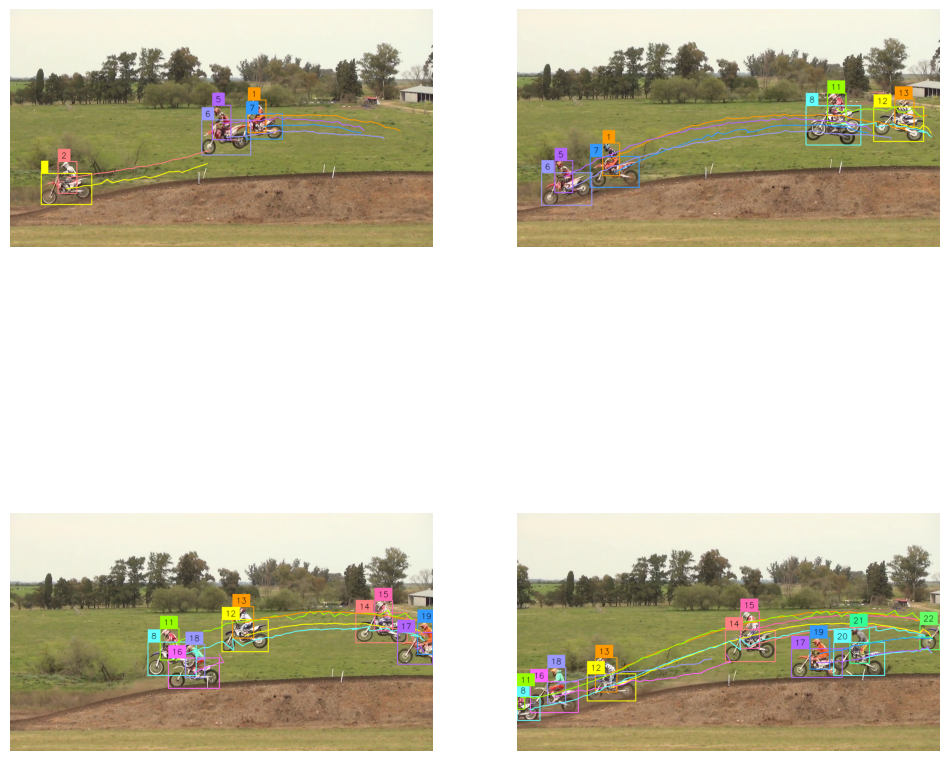

In [8]:
sv.plot_images_grid(images=frame_samples[:4], grid_size=(2, 2))

Just combined SORT with an `inference` detector—nice work! `trackers` makes it easy to mix and match top-performing multi-object tracking algorithms with your favorite detection backends, including `inference`, `ultralytics`, and `transformers`.

Ready to go deeper. Explore more tracking algorithms and integrations in the trackers [Documentation](https://roboflow.github.io/trackers/develop/) or dive into the code on [GitHub](https://github.com/roboflow/trackers). Got feedback or ideas, open an issue on [GitHub Issues](https://github.com/roboflow/trackers/issues).